# **PHYS 481 - Computational Physics II**

## **Assignment #4 - Regression and Machine Learning**

### **NAME:** Scott Salmon

### **UCID:** 30093320

### **FILE:** a3_scottsalmon.ipynb

### **DATES:** 2024/10/04 - 2024/10/08

In [6]:
from sklearn.neural_network import MLPRegressor
from numpy.polynomial.polynomial import Polynomial

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import os

On D2L, there are 2 datasets: daily sunspot number since 1818 (SN_d_tot_V2.0.csv) and geomagnetic indices (Kp and Ap) since 1932 (Kp_def.zip). The sunspot number data are from the World Data Center SILSO, Royal Observatory of Belgium, Brussels (https://www.sidc.be/SILSO/datafiles), while the geomagnetic data are from the GFZ German Research Centre for Geosciences, Potsdam, Germany (https://datapub.gfz-potsdam.de/download/10.5880.Kp.0001/). There is also a PDF description for the geomagnetic data (kp_index_data_description_20210311.pdf). Download the data from D2L to a local directory and unzip the zip file.

**Data References:**

Matzka, J., Bronkalla, O., Tornow, K., Elger, K., Stolle, C., 2021. "Geomagnetic Kp index". V. 1.0. GFZ Data Services. https://doi.org/10.5880/Kp.0001

SILSO World Data Center, 2024. "The International Sunspot Number", International Sunspot Number Monthly Bulletin and online catalogue, Royal Observatory of Belgium, avenue Circulaire 3, 1180 Brussels, Belgium, http://www.sidc.be/silso/

## Question 1: Look at the data before you use it

From the sunspot number CSV file, extract the date (first 3 columns) and the sunspot number (5th column). From the Kp_def files, extract the date (first 6 characters) and the daily Ap index (characters 56, 57 and 58, counting the first character as "1"). Trim the sunspot dataset to start at the same day as the Ap dataset (1932-01-01), check that the resulting datasets are the same length, and plot both datasets. You should see a clear 11-year period in the sunspot data and a less-clear 11-year period in Ap.

**HINT**: You may wish to store the date as a numpy datetime64 type. For example:

    date = np.datetime64(f"{year:04d}-{month:02d}-{day:02d}").

This will make it easier to display the data without worrying about things like leap years.



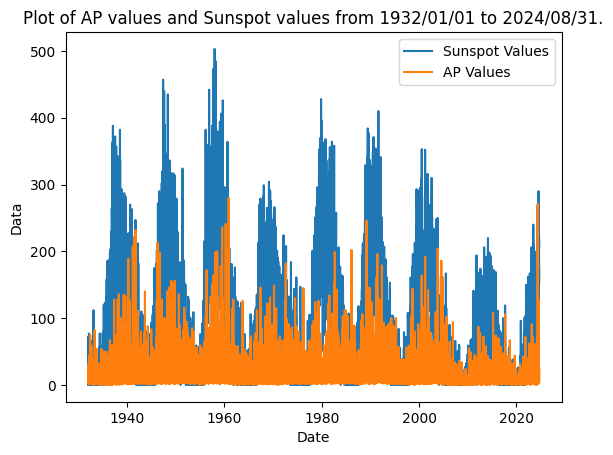

In [7]:
def load_Ap_data(directory):
    
    """
    Load Ap index data from a specified directory.
    This function reads Ap index data files for the years 1932 to 2024 from the given directory.
    Each file is expected to be named in the format "Kp_def{year}.wdc". The function extracts
    the date and Ap index value from each file, skipping lines that start with a "#".
    Parameters:
        directory (str): The path to the directory containing the Ap index data files.
    Returns:
        dates (numpy.ndarray): An array of dates corresponding to the Ap index values.
        data (numpy.ndarray): An array of Ap index values.
    """
    
    dates = []
    data = []
    for year in range(1932, 2025):
        filename = f"Kp_def{year}.wdc"
        filepath = os.path.join(directory, filename)
        if os.path.exists(filepath):
            with open(filepath, 'r') as file:
                for line in file:
                    if line[0] == "#":
                        continue
                    date = line[:6]
                    date = date.replace(' ', '0')
                    date = np.datetime64(f"{year}-{date[2:4]}-{date[4:6]}")
                    dates.append(date)
                    value = line[55:58].strip()
                    data.append(np.float64(value))
    return np.squeeze(dates),np.squeeze(data)


def load_sunspot_data(filename):
    
    '''This function loads sunspot data from the csv file. It takes in a filename as a parameter and outputs a date array and sunspot array.'''
    
    with open(filename, 'r') as f:
        sunspot = np.array([])
        
        for line in f:
            data = line.split(";")
            
            #clips all data lower then 1931
            if int(data[0]) > 1931:
                if len(sunspot) != 0:
                    date = np.append(date, np.datetime64(f"{int(data[0]):04d}-{int(data[1]):02d}-{int(data[2]):02d}"))
                    sunspot = np.append(sunspot, np.array([int(data[4])]))
                else:
                    date = np.datetime64(f"{int(data[0]):04d}-{int(data[1]):02d}-{int(data[2]):02d}")
                    sunspot = np.array([int(data[4])])
    
    return date, sunspot
    
def plot_q1(x, y, a, b):
    
    '''Plotting instructions for question 1. Takes in x y values for the sunspots and Ap data.'''
    
    plt.figure()
    plt.title("Plot of AP values and Sunspot values from 1932/01/01 to 2024/08/31.")
    plt.plot(x,y)
    plt.plot(a,b)
    plt.xlabel("Date")
    plt.ylabel("Data")
    plt.legend(['Sunspot Values', 'AP Values'])
    plt.show()

#loading data into variables, and then calling the plot function
x, y = load_sunspot_data("SN_d_tot_V2.0.csv")
a, b = load_Ap_data("Kp_def")
plot_q1(x,y,a,b)

# Question 2: Linear regression

The sunspot number is a measure of the magnetic activity of the sun and the solar wind. The Ap index is a measure of electrical currents generated in Earth's upper atmosphere in response to the solar wind. (The same electrical currents are responsible for the aurora.)  The solar wind takes a few days to get from the sun to the Earth, so there's no reason to suspect the Ap index varies on a day-to-day basis in response to the sunspot number, but the plot from Q1 already suggests there's some correlation over a longer period. Let's try averaging over the 27-day solar rotation period and performing a linear regression.

1. Filter (smooth) the Ap and sunspot data with a 27-day boxcar average.
2. Plot a heatmap of the joint probability distribution ("2d histogram") of the smoothed sunspot number (x) and Ap index (y). Normalize each vertical column in the 2d histogram (i.e. each slice of roughly-constant sunspot number) to sum to one. Include the marginal distributions ("1d histograms"). There is code in the template to assist you.
3. Using a package of your choice (numpy, scipy, scikit-learn, etc.), fit a linear least-squares fit to Ap versus sunspot number. Calculate $R^2$ and the root mean squared error (RMSE). Add the least-squares line to the plot of the joint probability function, with a label giving the equation of the line of best fit, $R^2$ and the RMSE.


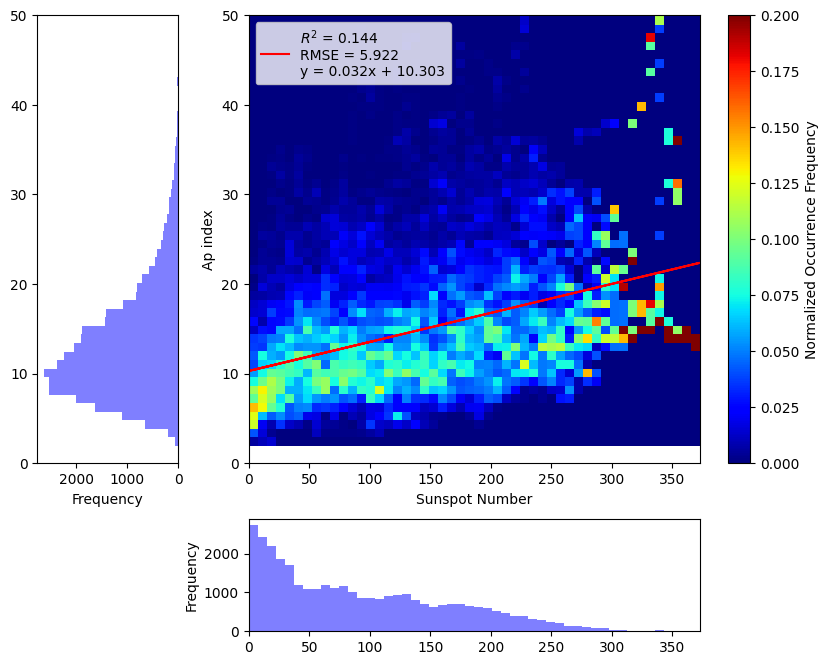

In [8]:
def joint_pdf_plot(sn, Ap, question = None, linear = 0, best_curve = 0, twenty_curve = 0, q4_rmse = 0):
    
    '''This is the primary plotting function used throughout the rest of the assignment. It requires sunspot and ap values. The rest of the parameters are optional.
    
        The question parameter can be filled with a string to apply the desired plotting settings for the respective question. The linear, best_curve and twenty_curve
        parameters are used in specific questions for plotting the desired curves. q4_rmse is only used in question 4 plot to show their rmse value.'''
    
    # Setup axes
    fig, axs = plt.subplots(2, 2, figsize=(10,8), gridspec_kw={'height_ratios': [4,1], 'width_ratios': [1,4]})

    # 2D histogram of the joint probability of Ap and sn
    nbins=50
    h = np.histogram2d(Ap, sn, bins=nbins)
    h_normalized = h[0] / h[0].sum(axis=0, keepdims=True)
    axs[0,1].imshow(h_normalized, origin='lower', aspect='auto', extent=[h[2][0], h[2][-1],h[1][0], h[1][-1]],cmap='jet', norm=plt.Normalize(0, 0.2))
    plt.colorbar(axs[0,1].images[0], ax=axs[0,1], orientation='vertical', label='Normalized Occurrence Frequency')

    #this setting is used to make our plot in question 2.
    if question == 'q2':
        equation = ("y = %0.5fx + %0.5f" %(linear.slope, linear.intercept)) #this makes the string for our equation
        line = linear.intercept + linear.slope*sn                           #this makes the actual line in the plot
        rmse =  np.sum((line-Ap)**2/len(line))**(0.5)                       #this calculates the rmse of the linear plot

        #plotting instructions
        axs[0, 1].plot(sn, line, 'r', label=equation)
        axs[0, 1].legend(['$R^2$ = %0.3f\nRMSE = %0.3f\ny = %0.3fx + %0.3f'%(linear.rvalue**2, rmse, linear.slope, linear.intercept)],loc='upper left')
    
    #this setting is used to make our plot in question 3.
    elif question == 'q3':
        line = linear.intercept + linear.slope*sn #this makes the actual line in the plot
        
        #plotting instructions
        axs[0, 1].plot(sn, line, 'red', label="Linear Fit")
        axs[0, 1].plot(sn, best_curve, color = 'yellow', label="6th Order Polynomial Fit")
        axs[0, 1].plot(sn, twenty_curve, '#FF13F0', label="20th Order Polynomial Fit")
        axs[0, 1].legend(loc = 'upper left')
    
    #this setting is used to make our plot in question 4.
    elif question == 'q4':
        x_range = np.linspace(min(sn), max(sn), 100).reshape(-1, 1)     #makes x_range for neural plot
        line = linear.intercept + linear.slope*sn                       #makes the actual line in the plot
        rmse =  np.sum((line-Ap)**2/len(line))**(0.5)                   #calculates the rmse for the linear plot
        
        #plotting instructions to make our plot in question 4.
        axs[0, 1].plot(sn, line, 'red', label="Linear Fit\nRMSE = %0.3f"%rmse)
        axs[0, 1].plot(x_range, best_curve, color='orange', label='Neural Network Fit\nRMSE = %0.3f'%q4_rmse)
        axs[0, 1].legend(loc = 'upper left')

    axs[0, 1].set_ylim(bottom=0.0, top=50)
    axs[0, 1].set_xlabel('Sunspot Number')
    axs[0, 1].set_ylabel('Ap index')

    # 1D histogram of sn
    axs[1, 1].hist(sn, bins=50, alpha=0.5, color='blue')
    axs[1, 1].set_ylabel('Frequency')
    axs[1, 1].set_xlim(axs[0, 1].get_xlim())
    axs[1, 1].set_position([axs[0, 1].get_position().x0, axs[1, 1].get_position().y0, axs[0, 1].get_position().width, axs[1, 1].get_position().height])

    # 1D histogram of Ap
    axs[0,0].hist(Ap, bins=50, alpha=0.5, color='blue', orientation='horizontal')
    axs[0,0].invert_xaxis()
    axs[0,0].set_xlabel('Frequency')
    axs[0,0].set_ylim(axs[0,1].get_ylim())

    # Remove the empty plot
    fig.delaxes(axs[1, 0])

    return axs

def joint_pdf_with_linear_fit(sn, Ap):
    
    '''Function creates our plot with a linear plot. All it requires is an sn and ap arrays as parameters.'''
    
    line = sp.stats.linregress(sn, Ap)          #makes the linear fit
    axs = joint_pdf_plot(sn, Ap, 'q2', line)    #calls the plotting function

    return axs

def smoothing(array, window):
    
    '''This function takes in a 1D array and smooths it out with whatever specified window. Only required parameters is the input array and window size.'''
    
    output = np.ones(window)/window                         #creates a output array filled with 1/window elements
    smoothed = np.convolve(array, output, mode = 'same')    #does the convolution with the output array and input array

    return smoothed

y = smoothing(y, 27)
b = smoothing(b, 27)
joint_pdf_with_linear_fit(y, b);

# Question 3: Polynomial Fits and Under- and Over-fitting

The linear fit in the previous question seems to miss a feature at low sunspot number, where the Ap data trends to zero. Let's see if we can pull that out with a nonlinear fit.

1. Split the data into a training set consisting of the first 70% of the data points and a validation set consisting of the remainder.
2. Fit the training set using polynomials from order one through order 20. (Use Polynomial.fit from numpy.polynomial.polynomial or a similar package.)
3. Plot the RMSE on the training set and the RMSE on the validation set as a function of polynomial order.
4. Choose the optimal order for the polynomial fit (i.e. the polynomial fit that best reduces the RMSE on the **validation** set)
5. Plot the joint probability distribution with:
    - the linear fit
    - the optimal polynomial fit 
    - the polynomial fit with order 20

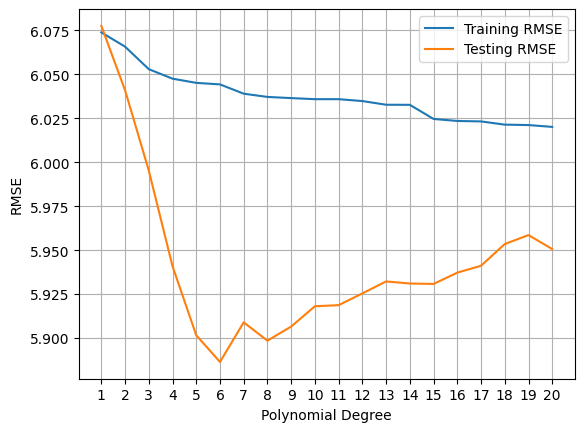

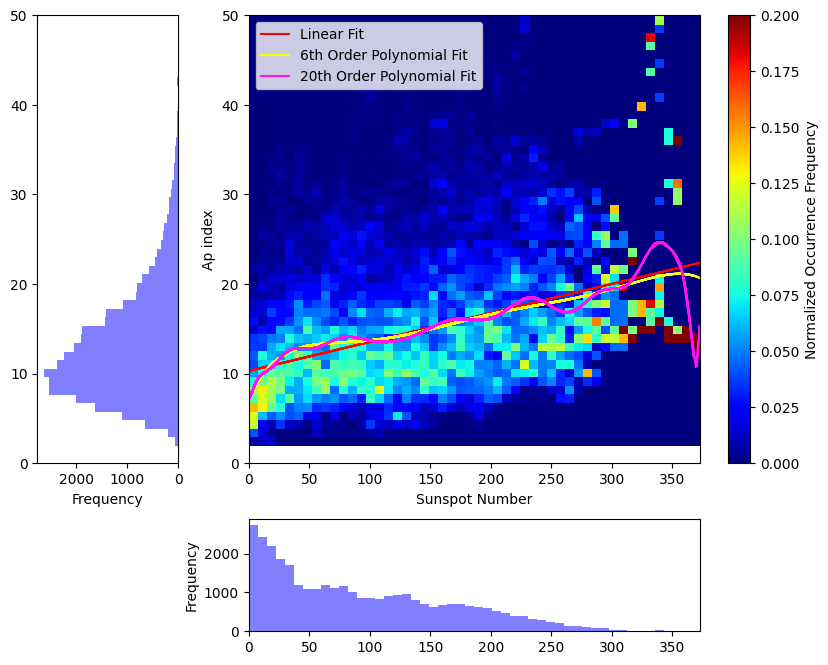

In [9]:
def splitter(x,y,decimal):
    
    '''This function is used to split data into training/testing sets. It takes in an x and y array, and the decimal of what you want in the training set.'''
    
    #finds which index we're splitting the arrays at
    split_index = int(len(y) * decimal)
    
    #creates training datasets
    x_tr = x[:split_index]
    y_tr = y[:split_index]

    #creates test datasets
    x_te = x[split_index:]
    y_te = y[split_index:]
    
    return x_tr, x_te, y_tr, y_te

def find_best_polynomial_order(sn_training, sn_test, ap_training, ap_testing):
    
    '''This function takes in training/testing arrays and then creates a polynomial curve fit 1-20 and tries to find the most optimal fit.
        It then creates a plot comparing the training and testing rmse values for every curve fit. Finally, it returns the integer for the best fit.'''
    
    #initializing lists for storage and a storage variable
    train_rmse = []
    val_rmse = []
    saved = 20
    
    #loops from order 1-20
    for i in range(1,21):
        
        #makes the polynomial fit using only the training data
        poly_fit = Polynomial.fit(sn_training, ap_training, i)
        
        #makes a curve using the fit we made and teh training/test data respectively
        curve_training = poly_fit(sn_training)
        curve_testing = poly_fit(sn_test)
        
        #calculates the rmse for the training/test data respectively, and adds values to lists
        rmse_training = np.sqrt(np.sum((curve_training - ap_training)**2) / len(curve_training))
        rmse_testing = np.sqrt(np.sum((curve_testing - ap_testing)**2) / len(curve_testing))
        train_rmse.append(rmse_training)
        val_rmse.append(rmse_testing)
        
        #this if statement is checking if the current test rmse is the lowest we've seen yet. If so, save the polynomial order
        if rmse_testing < saved:
            best = i
            saved = rmse_testing

    #plot instructions for RMSE vs. Order
    plt.figure()
    plt.plot(range(1,21), train_rmse, label='Training RMSE')
    plt.plot(range(1,21), val_rmse, label='Testing RMSE')
    plt.legend()
    plt.xticks(range(1, 21))  # 1 to 20, no decimals
    plt.xlabel('Polynomial Degree')
    plt.ylabel('RMSE')
    plt.grid()
    plt.show()
    
    #returning the most optimal polynomial order
    return best

def joint_pdf_with_polynomial_fit(sn_smoothed, Ap_smoothed, best_order):
    
    '''This function takes in an sn array, ap array, and the predetermined best fit order for the polynomial fit.'''
    
    #makes a linear line of best fit using scipy method
    line = sp.stats.linregress(sn_smoothed, Ap_smoothed)

    #makes polynomial curve of best fit using polynomial with optimal degree fed into the function
    fit = Polynomial.fit(sn_smoothed, Ap_smoothed, best_order)
    curve = fit(sn_smoothed)
    
    #makes polynomial curve of best fit using polynomial of degree 20
    fit = Polynomial.fit(sn_smoothed, Ap_smoothed, 20)
    twenty = fit(sn_smoothed)
    
    #calling plot function with q3 setting
    axs = joint_pdf_plot(sn_smoothed, Ap_smoothed, 'q3', line, curve, twenty)
    
    return axs

#splitting data set into 70% vs. 30% training vs. testing
y_tr, y_te, b_tr, b_te = splitter(y, b, 0.7)

# First plot: RMSE vs polynomial order, and returns best order value
best_order = find_best_polynomial_order(y_tr, y_te, b_tr, b_te)

# Second plot: Joint PDF with polynomial fits
joint_pdf_with_polynomial_fit(y,b,best_order);

# Question 4: Neural Networks

As an alternative to the polynomial fitting from the previous question, use a neural network to fit the Ap index as a function of sunspot number. 
1. To reduce computation time and increase independence of the points, take every 27th point from the smoothed sunspot number and smoothed Ap to use as the x and y values for the regression.
2. Using the Multi-Layer Perceptron regressor (MLPRegressor) from scikit-learn, train a neural network to predict Ap as a function of sunspot number. The problem is relatively small and simple, so you don't need many layers (1 or 2 should suffice) or a large numbers of neurons (100 is plenty). The relu activation function should work well.
3. Calculate the RMSE for the fit.
4. Re-plot the joint probability distribution with the linear fit and the neural network fit.

[**NOTE**: To check for under- or over-fitting, we could split the data into training and validation sets like in the last question, and search for an optimal set of hyperparameters for the neural network (number of neurons, activation function, regularization parameter alpha, etc.). That's not required here.]

[**HINT**: This is very similar to the fit performed in the textbook: https://pythonnumericalmethods.studentorg.berkeley.edu/notebooks/chapter25.03-Regression.html ]


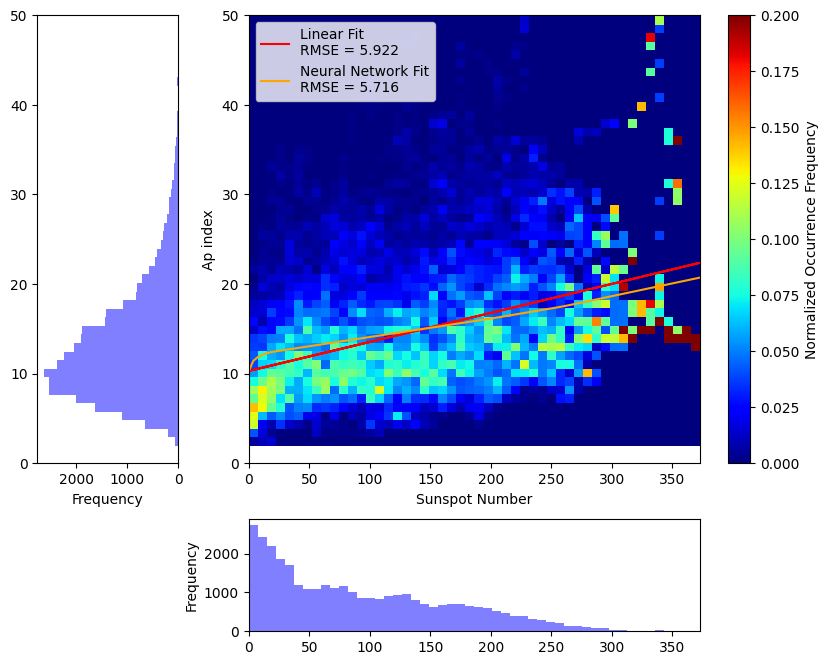

In [10]:
#this resizes our data sets to only account for 1/27 points
y_r = y[::27].reshape(-1, 1)  #Reshape for sklearn
b_r = b[::27]                 

#splitting data set into 70% vs. 30% training vs. testing
y_tr, y_te, b_tr, b_te = splitter(y_r, b_r, 0.7)

#Create the MLP regressor, 100 neurons in 1 layer
mlp = MLPRegressor(hidden_layer_sizes=(100,), activation='relu', max_iter=100000, random_state = 69420)

#creates fit with the neural network
mlp.fit(y_tr, b_tr)                                                        

#applies best fit with test data, and finds rmse from test data
y_pred = mlp.predict(y_te)                                                     
rmse = np.sqrt(np.sum((y_pred - b_te)**2) / len(b_te))

#reshaping back into 1D array for plot
x_range = np.linspace(min(y_r), max(y_r), 100).reshape(-1, 1) 
curve = mlp.predict(x_range)

#making linear fit for plot
linear_fit = sp.stats.linregress(y, b)

#calling plot function with q4 setting
joint_pdf_plot(y, b, 'q4', linear_fit, curve, q4_rmse = rmse);